In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, LeaveOneOut, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, make_scorer)
from sklearn.utils import resample
from tqdm import tqdm


In [35]:
# Load dataset
data = pd.read_csv(r"C:\Users\User\Downloads\creditcard.csv\creditcard.csv")
X = data.drop('Class', axis=1)
y = data['Class']

In [36]:
# Take stratified subset of 1000 samples for feasible computation
sss = StratifiedShuffleSplit(n_splits=1, train_size=1000, random_state=42)
for train_idx, _ in sss.split(X, y):
    X_small = X.iloc[train_idx]
    y_small = y.iloc[train_idx]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), ['Time', 'Amount'])],
    remainder='passthrough'
)

In [37]:
# Initialize models
models = {
    'KNN': make_pipeline(preprocessor, KNeighborsClassifier()),
    'Naive Bayes': make_pipeline(preprocessor, GaussianNB()),
    'Decision Tree': make_pipeline(preprocessor, DecisionTreeClassifier(random_state=42))
}


In [38]:
# Custom G-mean metric
def g_mean_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape != (2, 2):
        return 0.0
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return np.sqrt(sensitivity * specificity)


In [39]:
# Evaluation metrics
metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'gmean': make_scorer(g_mean_score)
}

In [40]:
# Modified LOOCV evaluation with progress tracking
def evaluate_loocv(model, X, y):
    n_samples = len(X)
    acc, prc, rec, f1, gm = [], [], [], [], []
    
    for i in tqdm(range(n_samples), desc='LOOCV Progress'):
        train_idx = np.delete(np.arange(n_samples), i)
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[[i]], y.iloc[[i]]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        acc.append(accuracy_score(y_test, y_pred))
        prc.append(precision_score(y_test, y_pred, zero_division=0))
        rec.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        gm.append(g_mean_score(y_test, y_pred))
    
    return {
        'accuracy': np.mean(acc),
        'precision': np.mean(prc),
        'recall': np.mean(rec),
        'f1': np.mean(f1),
        'gmean': np.mean(gm)
    }

In [41]:
# Bootstrap evaluation
def evaluate_bootstrap(model, X, y, n_iter=50):
    acc, prc, rec, f1, gm = [], [], [], [], []
    for _ in range(n_iter):
        X_train, y_train = resample(X, y, stratify=y, replace=True)
        oob_idx = ~X.index.isin(X_train.index)
        if sum(oob_idx) == 0:
            continue
        model.fit(X_train, y_train)
        y_pred = model.predict(X[oob_idx])
        acc.append(accuracy_score(y[oob_idx], y_pred))
        prc.append(precision_score(y[oob_idx], y_pred, zero_division=0))
        rec.append(recall_score(y[oob_idx], y_pred))
        f1.append(f1_score(y[oob_idx], y_pred))
        gm.append(g_mean_score(y[oob_idx], y_pred))
    return {
        'accuracy': np.mean(acc),
        'precision': np.mean(prc),
        'recall': np.mean(rec),
        'f1': np.mean(f1),
        'gmean': np.mean(gm)
    }


In [42]:
# Full evaluation process
results = []
for model_name in models:
    print(f"\n{'='*40}\nEvaluating {model_name}\n{'='*40}")
    
    # K-fold
    print("Running k-fold cross-validation...")
    kfold = cross_validate(models[model_name], X_small, y_small, cv=5, scoring=metrics)
    results.append({
        'Model': model_name,
        'Resampling': 'k-fold',
        'Accuracy': np.mean(kfold['test_accuracy']),
        'Precision': np.mean(kfold['test_precision']),
        'Recall': np.mean(kfold['test_recall']),
        'F1': np.mean(kfold['test_f1']),
        'G-Mean': np.mean(kfold['test_gmean'])
    })
    
    # LOOCV
    print("Running Leave-One-Out Cross-Validation...")
    loocv = evaluate_loocv(models[model_name], X_small, y_small)
    results.append({
        'Model': model_name,
        'Resampling': 'LOOCV',
        'Accuracy': loocv['accuracy'],
        'Precision': loocv['precision'],
        'Recall': loocv['recall'],
        'F1': loocv['f1'],
        'G-Mean': loocv['gmean']
    })
    
    # Bootstrap
    print("Running Bootstrapping...")
    bootstrap = evaluate_bootstrap(models[model_name], X_small, y_small)
    results.append({
        'Model': model_name,
        'Resampling': 'Bootstrap',
        'Accuracy': bootstrap['accuracy'],
        'Precision': bootstrap['precision'],
        'Recall': bootstrap['recall'],
        'F1': bootstrap['f1'],
        'G-Mean': bootstrap['gmean']
    })

# Create results DataFrame
results_df = pd.DataFrame(results)


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classif


Evaluating KNN
Running k-fold cross-validation...
Running Leave-One-Out Cross-Validation...


LOOCV Progress:   0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass 

Running Bootstrapping...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData


Evaluating Naive Bayes
Running k-fold cross-validation...
Running Leave-One-Out Cross-Validation...


LOOCV Progress:   0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass 

Running Bootstrapping...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData


Evaluating Decision Tree
Running k-fold cross-validation...
Running Leave-One-Out Cross-Validation...


LOOCV Progress:   0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass 

Running Bootstrapping...


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

C:\Users\User\AppData\Local\Temp\ipykernel_6456\4244864027.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Metric', y='Value', hue='Resampling', data=melt_df,
C:\Users\User\AppData\Local\Temp\ipykernel_6456\4244864027.py:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.barplot(x='Metric', y='Value', hue='Resampling', data=melt_df,


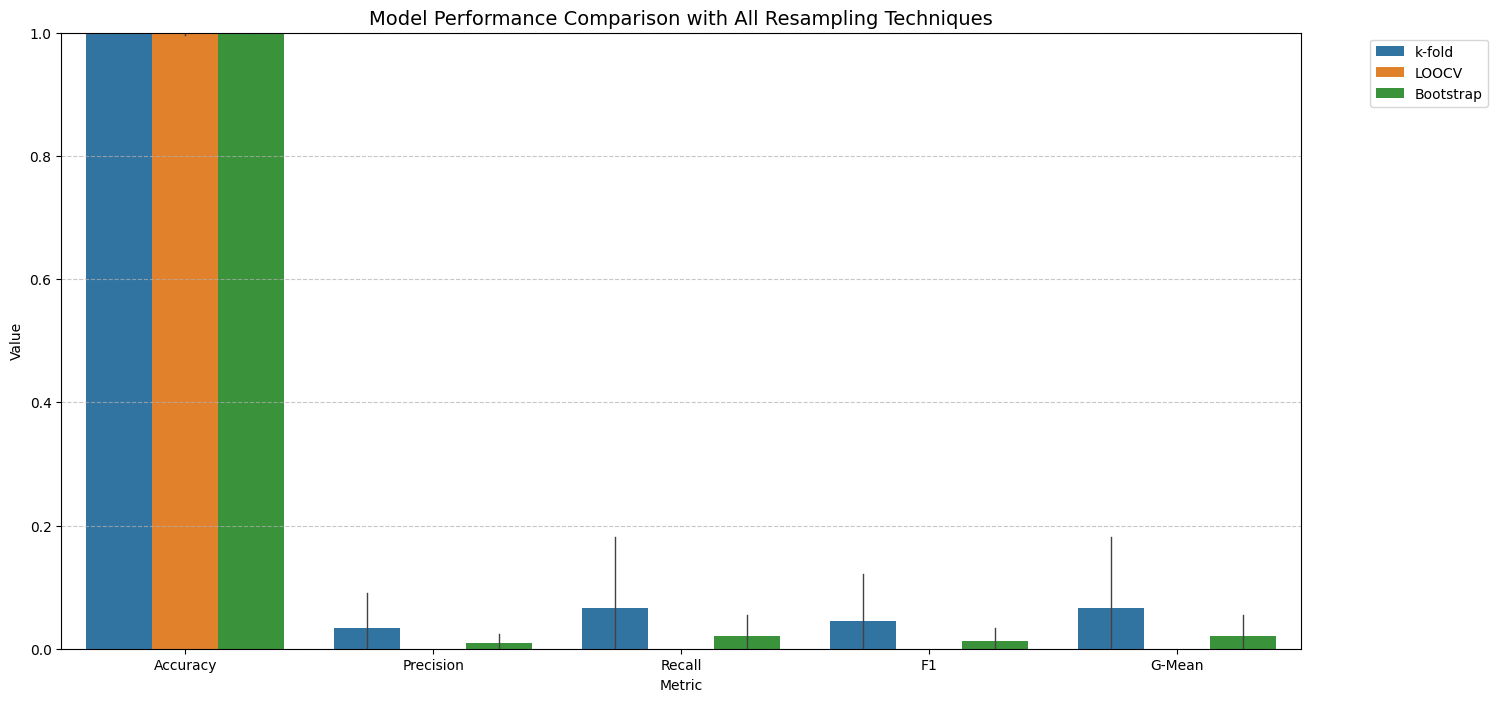

In [43]:
# Visualization
plt.figure(figsize=(16, 8))
melt_df = pd.melt(results_df, 
                 id_vars=['Model', 'Resampling'], 
                 value_vars=['Accuracy', 'Precision', 'Recall', 'F1', 'G-Mean'],
                 var_name='Metric', 
                 value_name='Value')

sns.barplot(x='Metric', y='Value', hue='Resampling', data=melt_df, 
            ci='sd', palette='tab10', errwidth=1)
plt.title('Model Performance Comparison with All Resampling Techniques', fontsize=14)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
